ML k-fold

In [19]:
import numpy as np
import pandas as pd
import time
import os
from datetime import timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score, log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
# Set parameters
data_path = "PQEvents_Ticket_csv.csv"
text_column_name = "Details"
label_column_name = "Cause"
n_splits = 5  # Number of folds for K-fold cross-validation

In [21]:
# Create directory for results
os.makedirs("./results", exist_ok=True)

In [22]:
# Function to plot confusion matrices
def plot_confusion_matrices(y_true, y_pred, label_encoder, title, ax=None):
    """Plot confusion matrix with readable labels"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    cm = confusion_matrix(y_true, y_pred)
    class_names = label_encoder.classes_
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names, 
                ax=ax)
    
    # Add labels
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(title)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    return ax

In [23]:
# Load and preprocess data
print("Loading and preprocessing data...")
df = pd.read_csv(data_path)

# First, clean up Cause column
df = df[~df['Cause'].isin(['Unknown', 'Undetermined'])]  # Remove rows with these values in Cause column 
df['Cause'] = df['Cause'].replace(['Customer Request', 'Customer Caused'], 'Customer')

# Replace Unknown/Undetermined in Isolation Equipment Code
df['Isolation Equipment Code'] = df['Isolation Equipment Code'].replace(['Unknown', 'Undetermined'], np.nan)

# Only drop rows where Cause is NaN
df = df.dropna(subset=['Cause'])

# If 'Cause' is 'Customer' and 'Isolation Equipment Code' is NaN, set 'Isolation Equipment Code' to 'Customer'
df.loc[(df['Cause'] == 'Customer') & (df['Isolation Equipment Code'].isna()), 'Isolation Equipment Code'] = 'Customer'

# Drop rows where 'Isolation Equipment Code' is NaN, but only for causes other than 'Customer'
df = df.dropna(subset=['Isolation Equipment Code'])

# Keep only rows where 'Details' is a string
df = df[df['Details'].apply(lambda x: isinstance(x, str))]

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply text cleaning
df['Details'] = df['Details'].apply(clean_text)

Loading and preprocessing data...


In [24]:
# Create label encoders
le_cause = preprocessing.LabelEncoder()
le_isolation = preprocessing.LabelEncoder()

# Fit both encoders
le_cause.fit(df[label_column_name].tolist())
le_isolation.fit(df['Isolation Equipment Code'].tolist())

# Transform labels
df['cause_label'] = le_cause.transform(df[label_column_name].tolist())
df['isolation_label'] = le_isolation.transform(df['Isolation Equipment Code'].tolist())

# TF-IDF Vectorizer for text data
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the number of features
X = vectorizer.fit_transform(df['Details']).toarray()
y_cause = df['cause_label']
y_isolation = df['isolation_label']

# Convert pandas Series to numpy arrays to avoid indexing issues with KFold
y_cause = np.array(df['cause_label'])
y_isolation = np.array(df['isolation_label'])


In [ ]:
# Initialize KFold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Display classes and their encoded values
print("\nCause Classes:")
for i, class_name in enumerate(le_cause.classes_):
    print(f"{i}: {class_name}")

print("\nIsolation Equipment Classes:")
for i, class_name in enumerate(le_isolation.classes_):
    print(f"{i}: {class_name}")

# ML Models Dictionary
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Radial Basis SVM': SVC(kernel='rbf', random_state=42),  # Enable probability for log_loss
    'Neural Network': MLPClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}



Cause Classes:
0: Animal
1: Customer
2: Equipment
3: Lightning
4: Other
5: Planned
6: Tree
7: Vehicle
8: Weather

Isolation Equipment Classes:
0: Breaker
1: CO15
2: CO15LB
3: Customer
4: Fuse
5: Fuse CO15
6: OCB
7: R-OVR-1PT
8: R100-4E
9: R100E
10: Recloser
11: SECT200NLB
12: Sectionalizer
13: Service Restorer
14: Switch


In [53]:
# Select the model you want to use for this run
current_model_name = 'Gradient Boosting'  # Change this to test different models
current_model = models[current_model_name]


####################################################################################################
Starting 5-fold cross-validation with Gradient Boosting model...
Target: CAUSE
####################################################################################################

Fold 1/5

Fold 1 Results:
Accuracy: 1.0000
Precision: 1.0000
F1 Score: 1.0000
Time: 0:00:00

Classification Report:
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         3
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        19
   Lightning       1.00      1.00      1.00         3
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00         4
     Vehicle       1.00      1.00      1.00         5

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



<Figure size 1200x1000 with 0 Axes>

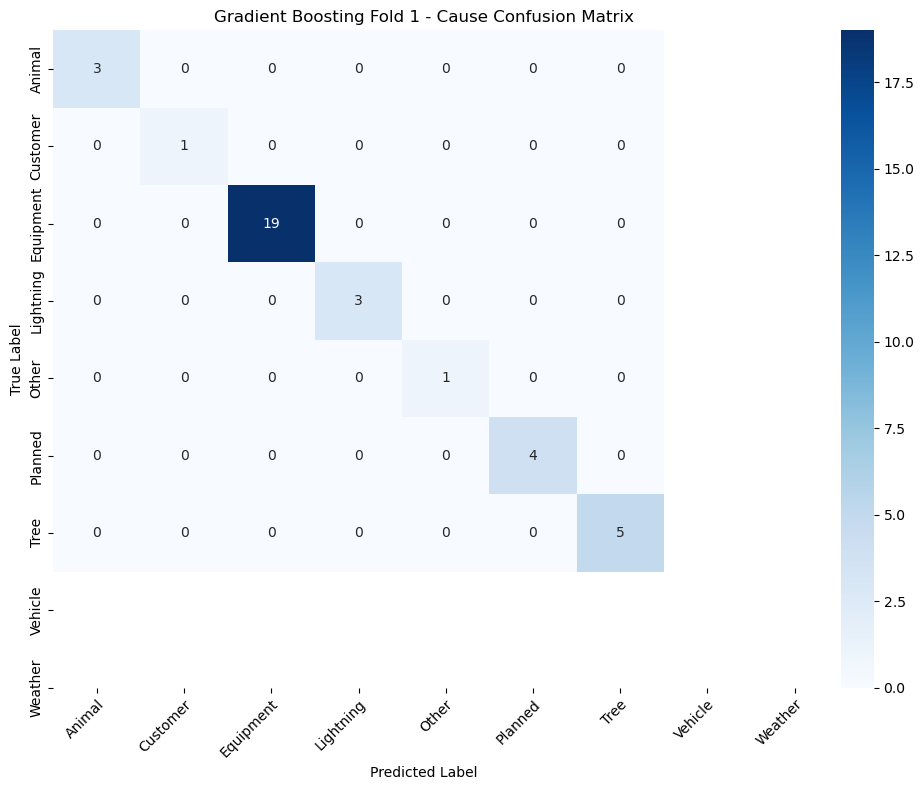


Fold 2/5

Fold 2 Results:
Accuracy: 0.9722
Precision: 0.9778
F1 Score: 0.9733
Time: 0:00:00

Classification Report:
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      0.93      0.96        14
   Lightning       0.80      1.00      0.89         4
       Other       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         7
     Weather       1.00      1.00      1.00         1

    accuracy                           0.97        36
   macro avg       0.97      0.99      0.98        36
weighted avg       0.98      0.97      0.97        36



<Figure size 1200x1000 with 0 Axes>

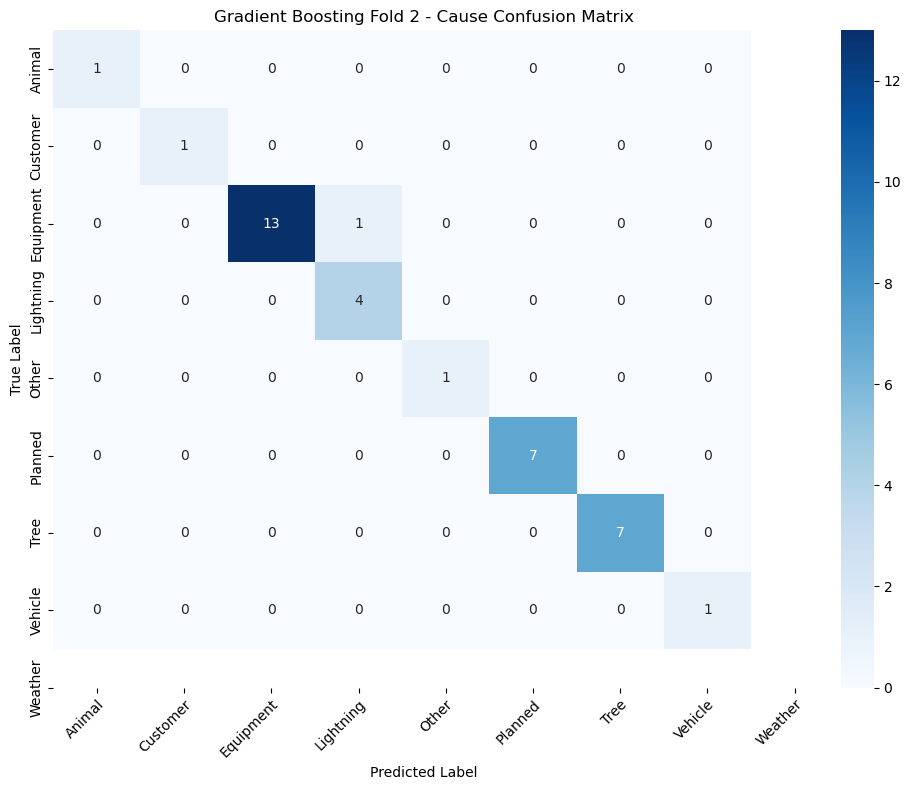


Fold 3/5

Fold 3 Results:
Accuracy: 1.0000
Precision: 1.0000
F1 Score: 1.0000
Time: 0:00:00

Classification Report:
              precision    recall  f1-score   support

      Animal       1.00      1.00      1.00         1
    Customer       1.00      1.00      1.00         1
   Equipment       1.00      1.00      1.00        13
   Lightning       1.00      1.00      1.00         2
       Other       1.00      1.00      1.00         1
     Planned       1.00      1.00      1.00         1
        Tree       1.00      1.00      1.00        12
     Vehicle       1.00      1.00      1.00         4
     Weather       1.00      1.00      1.00         1

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



<Figure size 1200x1000 with 0 Axes>

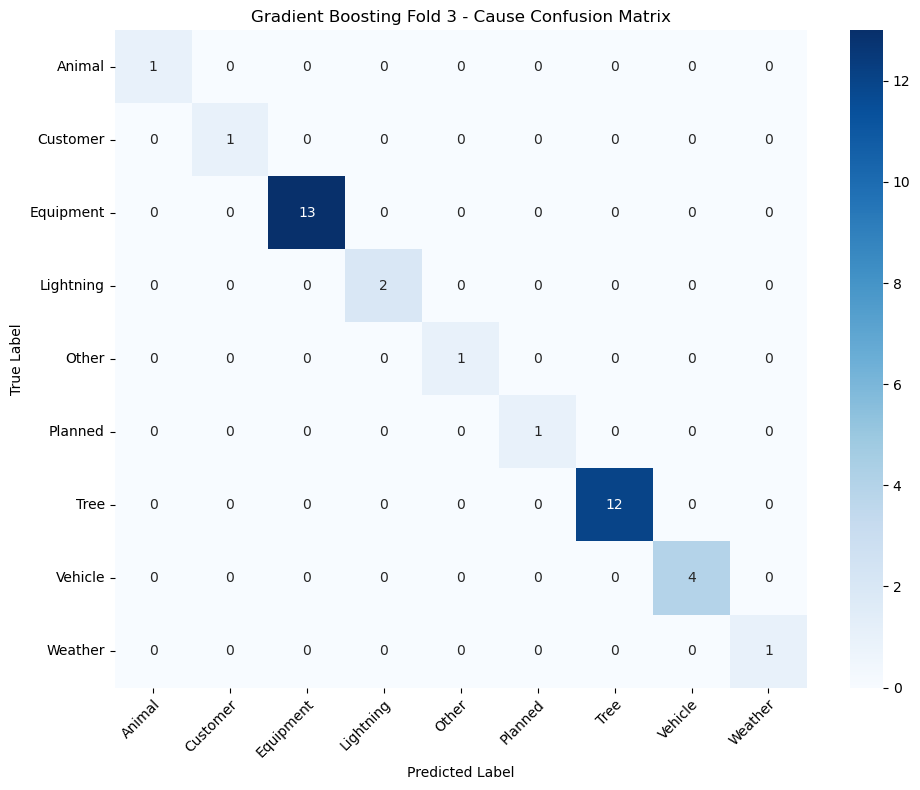


Fold 4/5

Fold 4 Results:
Accuracy: 0.8857
Precision: 0.8441
F1 Score: 0.8615
Time: 0:00:00

Classification Report:
              precision    recall  f1-score   support

    Customer       1.00      1.00      1.00         1
   Equipment       0.80      0.92      0.86        13
   Lightning       0.86      1.00      0.92         6
       Other       0.00      0.00      0.00         2
        Tree       1.00      0.89      0.94         9
     Vehicle       1.00      1.00      1.00         4

    accuracy                           0.89        35
   macro avg       0.78      0.80      0.79        35
weighted avg       0.84      0.89      0.86        35



<Figure size 1200x1000 with 0 Axes>

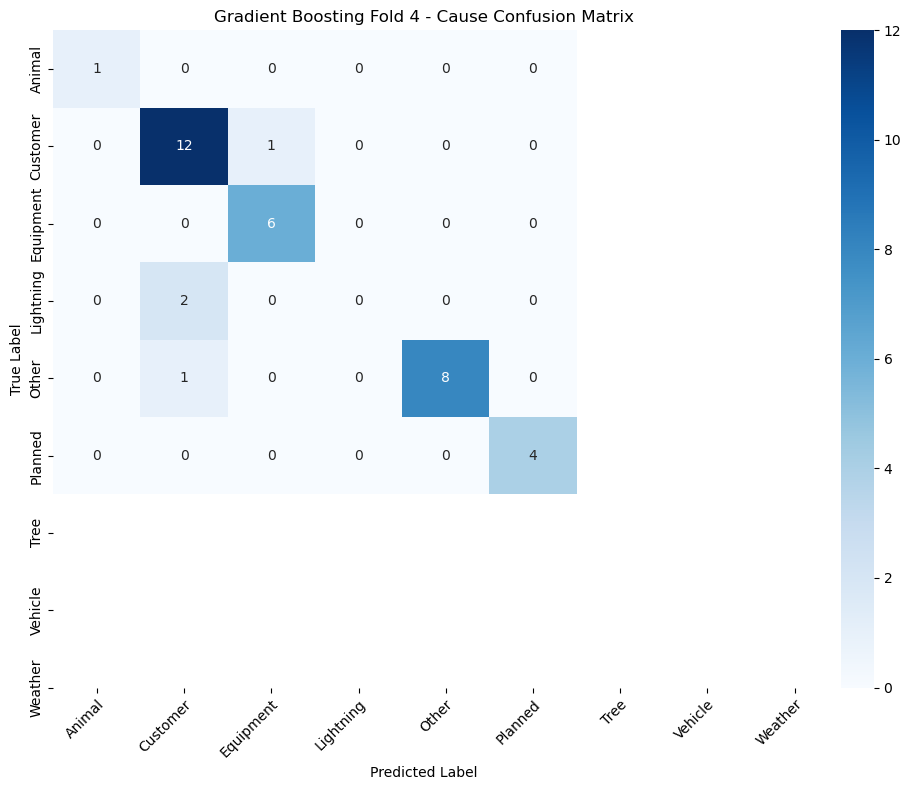


Fold 5/5

Fold 5 Results:
Accuracy: 0.9143
Precision: 0.8723
F1 Score: 0.8851
Time: 0:00:01

Classification Report:
              precision    recall  f1-score   support

      Animal       1.00      0.50      0.67         2
    Customer       0.00      0.00      0.00         2
   Equipment       0.82      1.00      0.90        14
   Lightning       1.00      1.00      1.00         6
        Tree       1.00      1.00      1.00         7
     Vehicle       1.00      1.00      1.00         3
     Weather       1.00      1.00      1.00         1

    accuracy                           0.91        35
   macro avg       0.83      0.79      0.80        35
weighted avg       0.87      0.91      0.89        35



<Figure size 1200x1000 with 0 Axes>

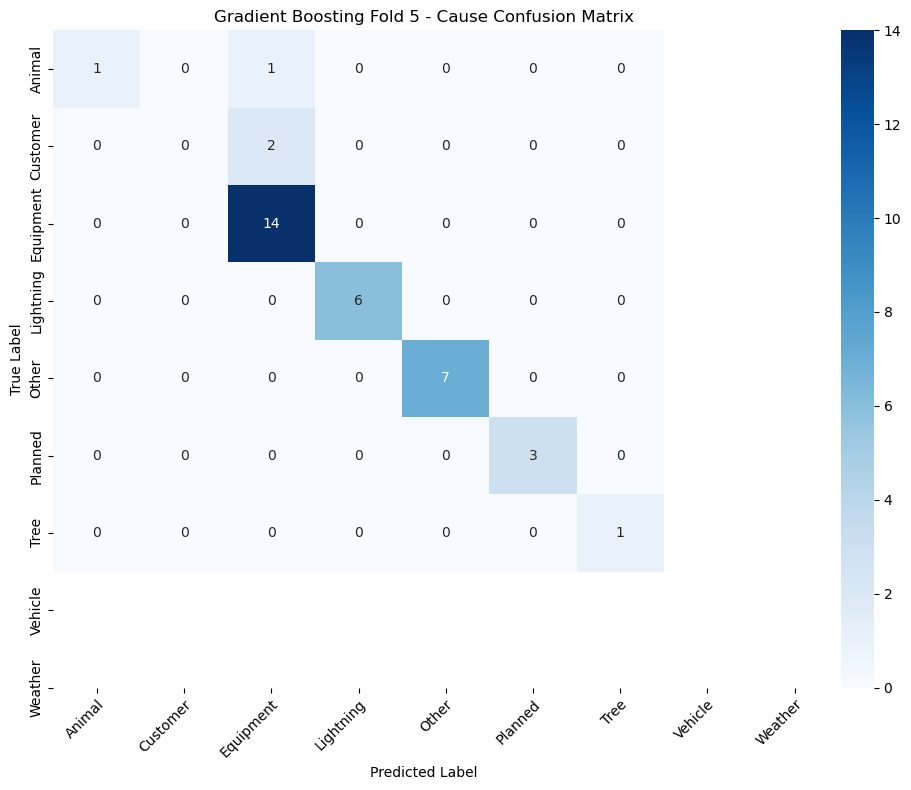


--------------------------------------------------
SUMMARY FOR CAUSE PREDICTION
--------------------------------------------------
Average Results Across All Folds:
Accuracy: 0.9544 (±0.0465)
Precision: 0.9388 (±0.0669)
F1 Score: 0.9440 (±0.0590)
Average Fold Time: 0:00:00


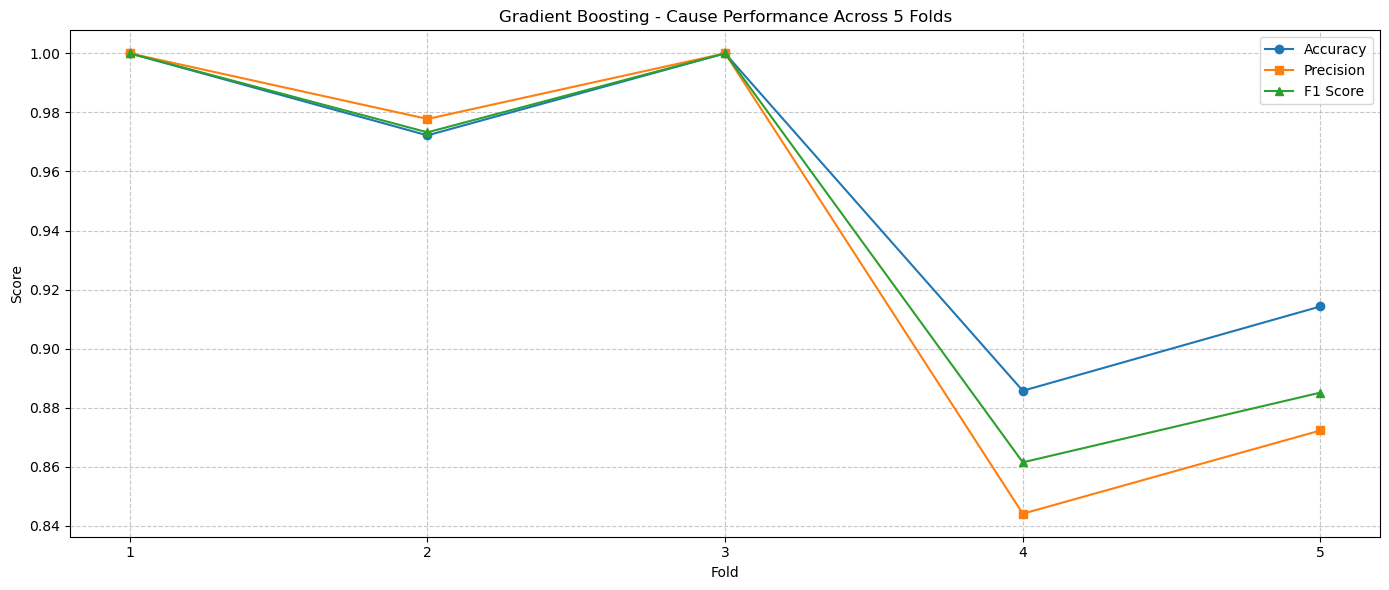


####################################################################################################
Starting 5-fold cross-validation with Gradient Boosting model...
Target: ISOLATION
####################################################################################################

Fold 1/5

Fold 1 Results:
Accuracy: 0.7500
Precision: 0.7810
F1 Score: 0.7339
Time: 0:00:01

Classification Report:
               precision    recall  f1-score   support

      Breaker       0.65      1.00      0.79        11
         CO15       0.00      0.00      0.00         2
     Customer       1.00      1.00      1.00         1
         Fuse       1.00      0.50      0.67         8
          OCB       0.00      0.00      0.00         1
    R-OVR-1PT       1.00      1.00      1.00         3
      R100-4E       1.00      1.00      1.00         1
     Recloser       1.00      0.80      0.89         5
   SECT200NLB       1.00      1.00      1.00         1
Sectionalizer       0.67      0.67      0.67  

<Figure size 1200x1000 with 0 Axes>

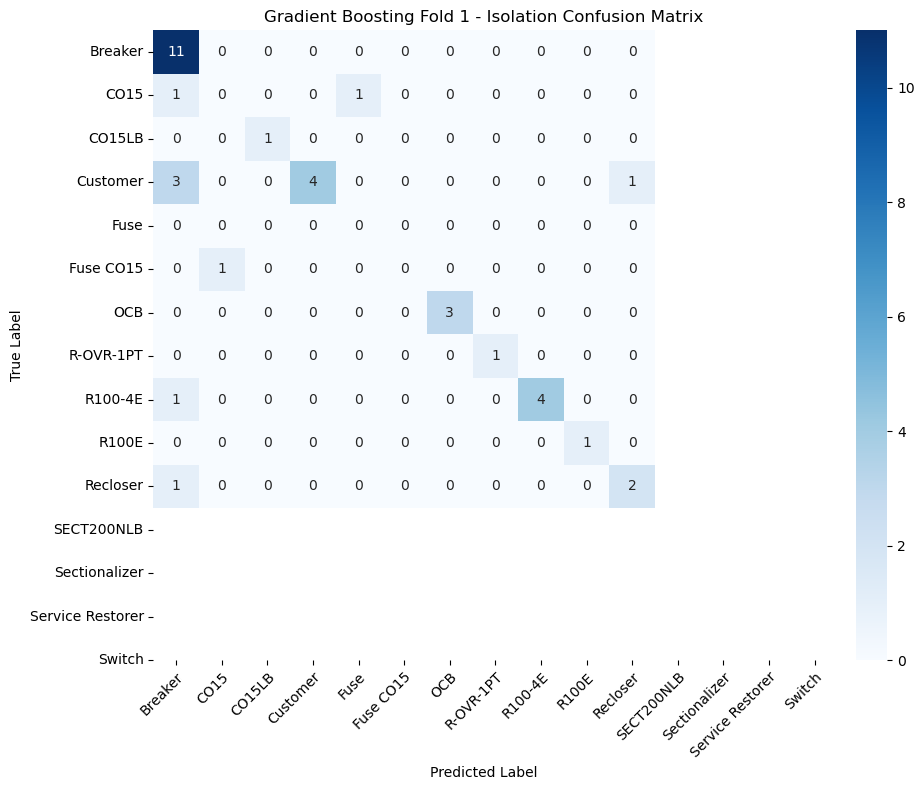


Fold 2/5

Fold 2 Results:
Accuracy: 0.8333
Precision: 0.8860
F1 Score: 0.8473
Time: 0:00:01

Classification Report:
               precision    recall  f1-score   support

      Breaker       0.89      0.85      0.87        20
         CO15       1.00      0.50      0.67         2
       CO15LB       0.00      0.00      0.00         1
     Customer       1.00      1.00      1.00         1
         Fuse       1.00      0.67      0.80         3
    R-OVR-1PT       1.00      1.00      1.00         1
      R100-4E       1.00      1.00      1.00         4
   SECT200NLB       1.00      1.00      1.00         2
Sectionalizer       0.50      1.00      0.67         2

    micro avg       0.88      0.83      0.86        36
    macro avg       0.82      0.78      0.78        36
 weighted avg       0.89      0.83      0.85        36



<Figure size 1200x1000 with 0 Axes>

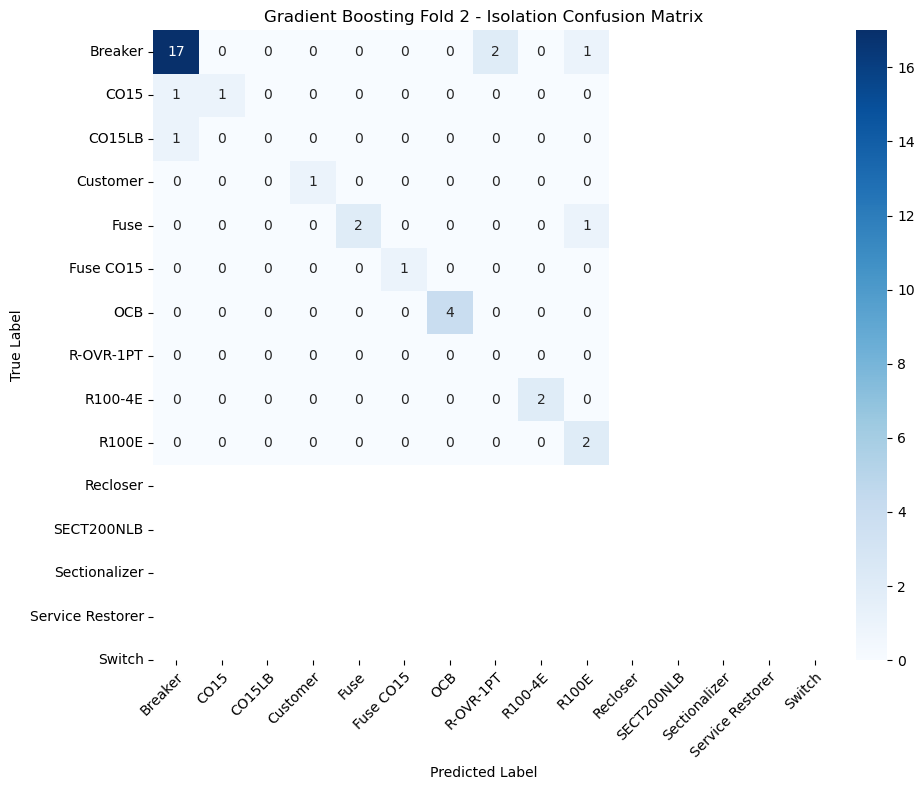


Fold 3/5

Fold 3 Results:
Accuracy: 0.9167
Precision: 0.9722
F1 Score: 0.9375
Time: 0:00:01

Classification Report:
               precision    recall  f1-score   support

      Breaker       0.95      0.95      0.95        19
         CO15       1.00      0.60      0.75         5
     Customer       1.00      1.00      1.00         1
         Fuse       1.00      1.00      1.00         2
    R-OVR-1PT       1.00      1.00      1.00         1
      R100-4E       1.00      1.00      1.00         1
     Recloser       1.00      1.00      1.00         4
   SECT200NLB       1.00      1.00      1.00         1
Sectionalizer       1.00      1.00      1.00         2

    micro avg       0.97      0.92      0.94        36
    macro avg       0.99      0.95      0.97        36
 weighted avg       0.97      0.92      0.94        36



<Figure size 1200x1000 with 0 Axes>

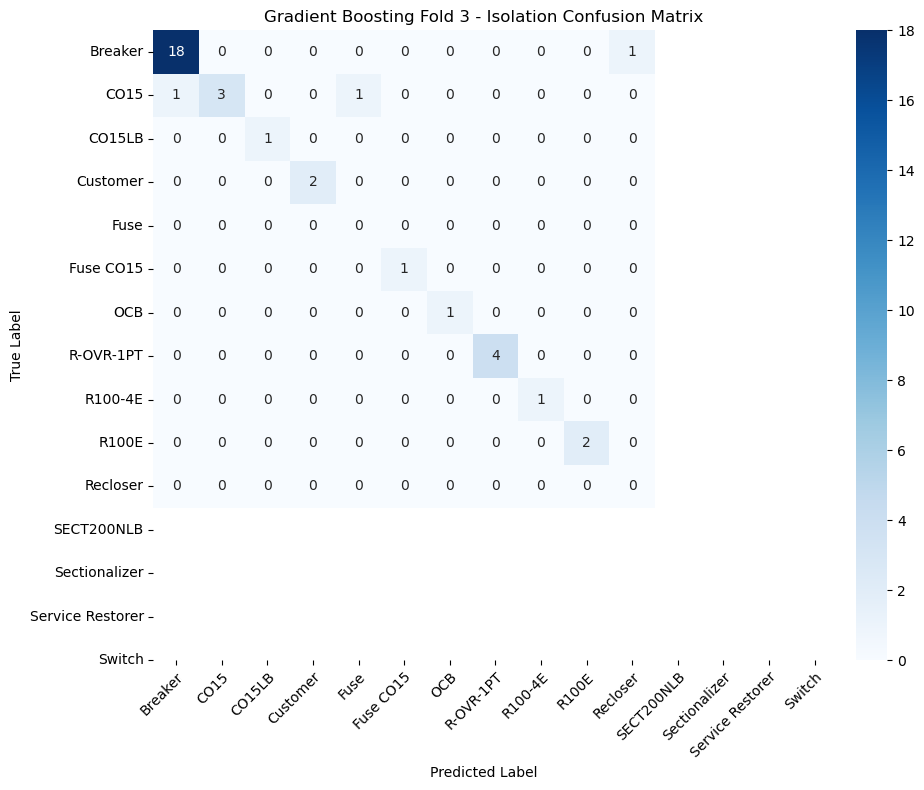


Fold 4/5

Fold 4 Results:
Accuracy: 0.7714
Precision: 0.8105
F1 Score: 0.7462
Time: 0:00:01

Classification Report:
               precision    recall  f1-score   support

      Breaker       0.58      1.00      0.73        11
         CO15       1.00      0.67      0.80         3
       CO15LB       1.00      0.33      0.50         3
     Customer       1.00      1.00      1.00         1
         Fuse       1.00      0.60      0.75         5
      R100-4E       1.00      1.00      1.00         3
     Recloser       1.00      1.00      1.00         4
Sectionalizer       1.00      0.67      0.80         3
       Switch       0.00      0.00      0.00         2

     accuracy                           0.77        35
    macro avg       0.84      0.70      0.73        35
 weighted avg       0.81      0.77      0.75        35



<Figure size 1200x1000 with 0 Axes>

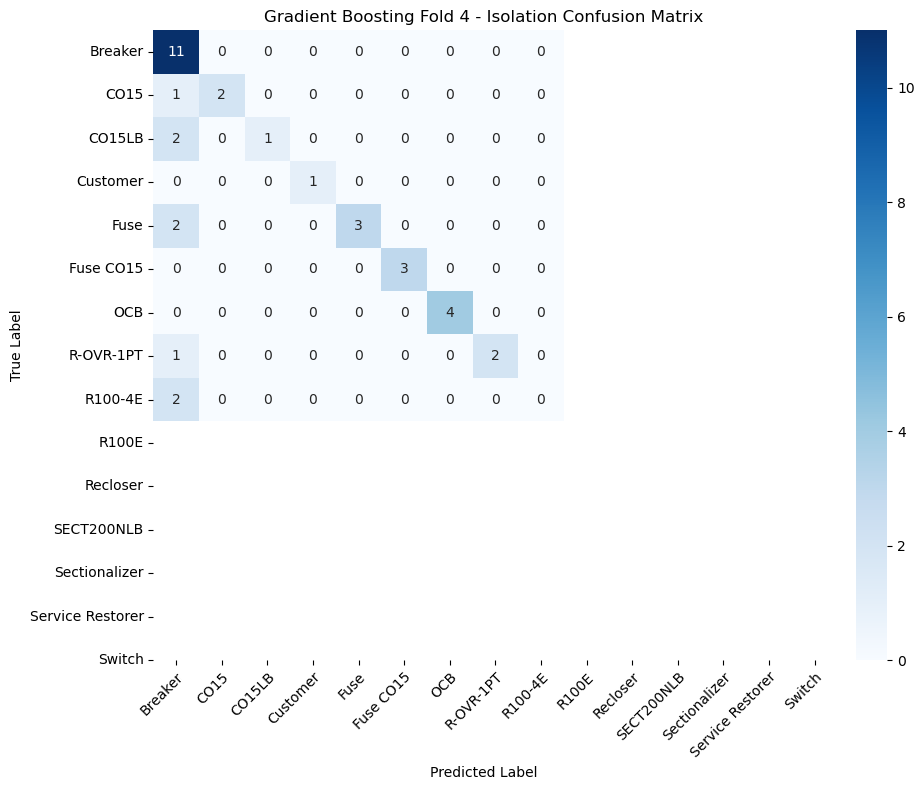


Fold 5/5

Fold 5 Results:
Accuracy: 0.6857
Precision: 0.5878
F1 Score: 0.6269
Time: 0:00:01

Classification Report:
                  precision    recall  f1-score   support

         Breaker       0.67      0.80      0.73        15
          CO15LB       0.50      0.33      0.40         3
        Customer       0.00      0.00      0.00         1
            Fuse       0.50      1.00      0.67         1
       Fuse CO15       0.00      0.00      0.00         1
       R-OVR-1PT       1.00      1.00      1.00         1
         R100-4E       1.00      1.00      1.00         4
           R100E       0.00      0.00      0.00         1
   Sectionalizer       0.71      1.00      0.83         5
Service Restorer       0.00      0.00      0.00         1
          Switch       0.00      0.00      0.00         2

       micro avg       0.71      0.69      0.70        35
       macro avg       0.40      0.47      0.42        35
    weighted avg       0.59      0.69      0.63        35



<Figure size 1200x1000 with 0 Axes>

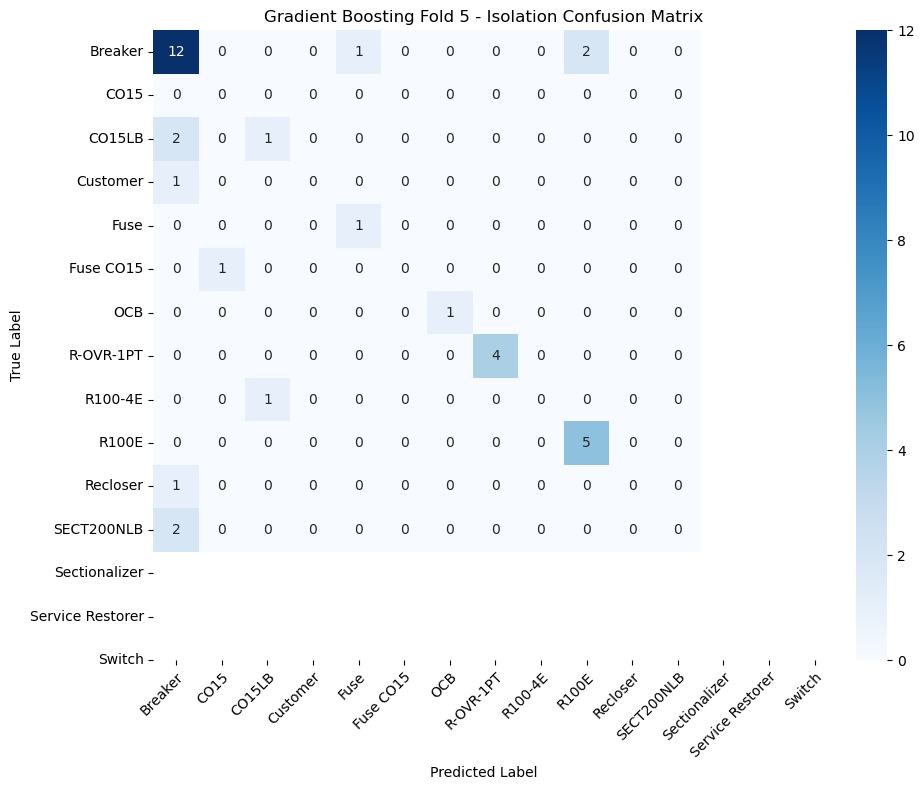


--------------------------------------------------
SUMMARY FOR ISOLATION PREDICTION
--------------------------------------------------
Average Results Across All Folds:
Accuracy: 0.7914 (±0.0784)
Precision: 0.8075 (±0.1283)
F1 Score: 0.7784 (±0.1058)
Average Fold Time: 0:00:01


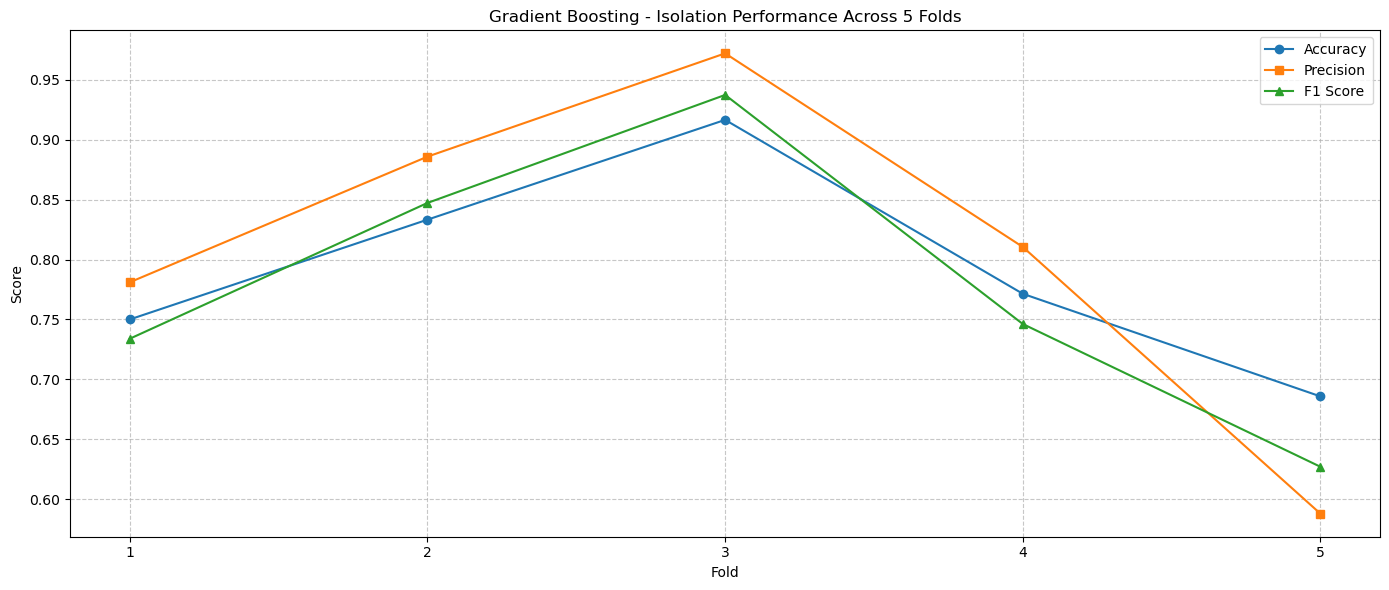

In [54]:
# Run k-fold cross-validation for both cause and isolation prediction
targets = ['cause', 'isolation']

for target_to_predict in targets:
    # Prepare result tracking
    fold_accuracies = []
    fold_precisions = []
    fold_f1_scores = []
    fold_times = []
    
    # K-fold cross-validation
    print(f"\n{'#'*100}")
    print(f"Starting {n_splits}-fold cross-validation with {current_model_name} model...")
    print(f"Target: {target_to_predict.upper()}")
    print(f"{'#'*100}")
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\n{'='*80}\nFold {fold+1}/{n_splits}\n{'='*80}")
        
        # Split data for this fold
        X_train, X_test = X[train_idx], X[test_idx]
        
        # Select appropriate target
        if target_to_predict == 'cause':
            y_train = y_cause[train_idx]
            y_test = y_cause[test_idx]
            le = le_cause
        else:  # isolation
            y_train = y_isolation[train_idx]
            y_test = y_isolation[test_idx]
            le = le_isolation
        
        # Train the model
        fold_start_time = time.time()
        current_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = current_model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # End fold timing
        fold_end_time = time.time()
        fold_time = fold_end_time - fold_start_time
        
        # Store fold results
        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_f1_scores.append(f1)
        fold_times.append(fold_time)
        
        # Print metrics for this fold
        print(f"\nFold {fold+1} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Time: {timedelta(seconds=int(fold_time))}")
        
        all_labels = le.classes_ # Assumes le.classes_ are the integer labels [0, 1, ..., 8]
        target_names_str = le.classes_

        print("\nClassification Report:")
        try:

            # Get unique labels present in the test set for this fold
            unique_test_labels = np.unique(y_test)
            # Get the corresponding class names
            target_names_present = le.inverse_transform(unique_test_labels)

            # Provide only the labels and target names present in y_test to classification_report
            print(classification_report(
                y_test,
                y_pred,
                labels=unique_test_labels, # Use only labels present in y_test
                target_names=target_names_present, # Use corresponding target names
                zero_division=0
            ))

        except Exception as e:
             print(f"Could not generate classification report: {e}")
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        plot_confusion_matrices(y_test, y_pred, le, f"{current_model_name} Fold {fold+1} - {target_to_predict.capitalize()} Confusion Matrix")
        plt.tight_layout()

        results_dir = 'results'

        filename = f"{current_model_name}_{target_to_predict}_fold{fold+1}_confusion_matrix.png"
        filepath = os.path.join(results_dir, filename)

        # Save the figure
        plt.savefig(filepath)

        plt.show()
    
    # Average metrics across all folds
    print(f"\n{'-'*50}")
    print(f"SUMMARY FOR {target_to_predict.upper()} PREDICTION")
    print(f"{'-'*50}")
    print("Average Results Across All Folds:")
    print(f"Accuracy: {np.mean(fold_accuracies):.4f} (±{np.std(fold_accuracies):.4f})")
    print(f"Precision: {np.mean(fold_precisions):.4f} (±{np.std(fold_precisions):.4f})")
    print(f"F1 Score: {np.mean(fold_f1_scores):.4f} (±{np.std(fold_f1_scores):.4f})")
    print(f"Average Fold Time: {timedelta(seconds=int(np.mean(fold_times)))}")
    
    # Plot overall performance across folds
    plt.figure(figsize=(14, 6))
    fold_nums = list(range(1, n_splits + 1))
    plt.plot(fold_nums, fold_accuracies, 'o-', label='Accuracy')
    plt.plot(fold_nums, fold_precisions, 's-', label='Precision')
    plt.plot(fold_nums, fold_f1_scores, '^-', label='F1 Score')
    plt.title(f'{current_model_name} - {target_to_predict.capitalize()} Performance Across {n_splits} Folds')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.xticks(fold_nums)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()